## Importações

In [1]:
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import laspy
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection


# from train_split import TrainSplit

## TranSplit

In [2]:
import geopandas
from shapely.geometry import Point, Polygon


class TrainSplit:
    @staticmethod
    def _get_records_in_plot_location(
        lidar_data: geopandas.GeoDataFrame, plot_location: geopandas.GeoDataFrame
    ) -> any:
        # return plot_location.contains(lidar_data)
        print(plot_location.items())
        return lidar_data.assign(
            **{key: lidar_data.within(geom) for key, geom in plot_location.items()}
        )

# Split Geometry

In [3]:
def katana(geometry, threshold, count=0):
    print("Geometry")
    print(type(geometry))
    print(geometry)

    """Split a Polygon into two parts across it's shortest dimension"""

    bounds = geometry.bounds

    width = bounds[2] - bounds[0]

    height = bounds[3] - bounds[1]

    print("width, height")

    print(width, height)

    if max(width, height) <= threshold or count == 250:

        # either the polygon is smaller than the threshold, or the maximum

        # number of recursions has been reached

        return [geometry]

    if height >= width:

        # split left to right

        a = box(bounds[0], bounds[1], bounds[2], bounds[1] + height / 2)

        b = box(bounds[0], bounds[1] + height / 2, bounds[2], bounds[3])

    else:

        # split top to bottom

        a = box(bounds[0], bounds[1], bounds[0] + width / 2, bounds[3])

        b = box(bounds[0] + width / 2, bounds[1], bounds[2], bounds[3])

    result = []

    for d in (
        a,
        b,
    ):

        c = geometry.intersection(d)

        if not isinstance(c, GeometryCollection):

            c = [c]

        for e in c:

            if isinstance(e, (Polygon, MultiPolygon)):

                result.extend(katana(e, threshold, count + 1))

    if count > 0:
        return result

    # convert multipart into singlepart

    final_result = []

    for g in result:

        if isinstance(g, MultiPolygon):

            final_result.extend(g)

        else:

            final_result.append(g)

    return final_result

## Carregamento dos dados

In [4]:
las = laspy.read(
    "C:/Users/joaov/Documents/UFMG/TCC/Dataset/DUC_A01_2017_LiDAR/DUC_A01_2017_LAS/DUCL0001C0004.las"
)

In [5]:
lidar_dataset = pd.DataFrame(las.xyz, columns=["X", "Y", "Z"])

In [6]:
geo_lidar_dataset = geopandas.GeoDataFrame(
    lidar_dataset,
    geometry=geopandas.points_from_xy(lidar_dataset.X, lidar_dataset.Y),
    crs="EPSG:32720",
)

In [7]:
inventory_plot_location: geopandas.GeoDataFrame = geopandas.read_file(
    "C:/Users/joaov/Documents/UFMG/TCC/Dataset/DUC_A01_2016_PLOTLOCATION/duc_a01_2016_plotlocation.shx"
)

In [8]:
inventory_plot_location.head()

,plot_ID,geometry
0,P20,"POLYGON ((840040.725 9674392.229, 840082.852 9..."
1,P02,"POLYGON ((840077.054 9674170.361, 840124.283 9..."
2,P07,"POLYGON ((840331.289 9673499.875, 840372.258 9..."
3,P09,"POLYGON ((840301.102 9673285.583, 840340.905 9..."
4,P08,"POLYGON ((839205.643 9673316.074, 839256.495 9..."


<Axes: >

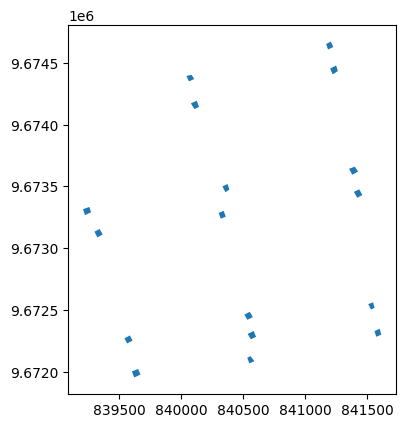

In [9]:
inventory_plot_location.plot()

In [10]:
# gdf = inventory_plot_location['geometry'].to_crs({'proj':'cea'})

In [11]:
# (gdf.area / 10**6).sum()

In [12]:
inventory = pd.read_csv(
    "C:/Users/joaov/Documents/UFMG/TCC/Dataset/DUC_A01_2016_inventory.csv",
    encoding="ISO-8859-1",
)

In [13]:
inventory.head()

,area,plot,tree,common.name,scientific.name,family.name,DBH,type,Dead,D.class,date,UTM.Easting,UTM.Northing
0,DUC_A01,2,001a,macucu,Licania guianensis,Chrysobalanaceae,49.6,O,False,NaN,20160824,840127.0705,9674180.998
1,DUC_A01,2,001b,uxirana,Sacoglottis guianensis,Humiriaceae,43.6,O,False,NaN,20160824,840098.9678,9674177.868
2,DUC_A01,2,002a,mapatirana,Pourouma minor,Urticaceae,31.5,O,False,NaN,20160824,840126.4377,9674180.705
3,DUC_A01,2,002b,abiurana,Pouteria gongrijpii,Sapotaceae,39.2,O,False,NaN,20160824,840109.4829,9674171.803
4,DUC_A01,2,003a,roxinho,Peltogyne lecointei,Fabaceae,10.0,O,False,NaN,20160824,840125.6847,9674181.313


In [14]:
inventory["plot"].unique()

array([ 2,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
      dtype=int64)

In [15]:
inventory_plot_location

,plot_ID,geometry
0,P20,"POLYGON ((840040.725 9674392.229, 840082.852 9..."
1,P02,"POLYGON ((840077.054 9674170.361, 840124.283 9..."
2,P07,"POLYGON ((840331.289 9673499.875, 840372.258 9..."
3,P09,"POLYGON ((840301.102 9673285.583, 840340.905 9..."
4,P08,"POLYGON ((839205.643 9673316.074, 839256.495 9..."
5,P11,"POLYGON ((839297.741 9673134.604, 839339.666 9..."
6,P10,"POLYGON ((841354.435 9673642.624, 841401.045 9..."
7,P12,"POLYGON ((841393.219 9673456.688, 841436.904 9..."
8,P04,"POLYGON ((841168.997 9674649.126, 841205.644 9..."
9,P05,"POLYGON ((841201.669 9674452.071, 841249.937 9..."


## Merge inventário com a região

In [16]:
geo_inventory_dataset = geopandas.GeoDataFrame(
    inventory,
    geometry=geopandas.points_from_xy(
        inventory["UTM.Easting"], inventory["UTM.Northing"]
    ),
    crs="EPSG:32720",
)

In [17]:
geo_inventory_dataset.head()

,area,plot,tree,common.name,scientific.name,family.name,DBH,type,Dead,D.class,date,UTM.Easting,UTM.Northing,geometry
0,DUC_A01,2,001a,macucu,Licania guianensis,Chrysobalanaceae,49.6,O,False,NaN,20160824,840127.0705,9674180.998,POINT (840127.071 9674180.998)
1,DUC_A01,2,001b,uxirana,Sacoglottis guianensis,Humiriaceae,43.6,O,False,NaN,20160824,840098.9678,9674177.868,POINT (840098.968 9674177.868)
2,DUC_A01,2,002a,mapatirana,Pourouma minor,Urticaceae,31.5,O,False,NaN,20160824,840126.4377,9674180.705,POINT (840126.438 9674180.705)
3,DUC_A01,2,002b,abiurana,Pouteria gongrijpii,Sapotaceae,39.2,O,False,NaN,20160824,840109.4829,9674171.803,POINT (840109.483 9674171.803)
4,DUC_A01,2,003a,roxinho,Peltogyne lecointei,Fabaceae,10.0,O,False,NaN,20160824,840125.6847,9674181.313,POINT (840125.685 9674181.313)


In [18]:
inventory_point_in_poly = geopandas.sjoin(
    geo_inventory_dataset,
    inventory_plot_location,
    predicate="within",
    lsuffix="left",
    rsuffix="right",
)

In [19]:
inventory_point_in_poly

,area,plot,tree,common.name,scientific.name,family.name,DBH,type,Dead,D.class,date,UTM.Easting,UTM.Northing,geometry,index_right,plot_ID
0,DUC_A01,2,001a,macucu,Licania guianensis,Chrysobalanaceae,49.6,O,False,NaN,20160824,840127.0705,9674180.998,POINT (840127.071 9674180.998),1,P02
1,DUC_A01,2,001b,uxirana,Sacoglottis guianensis,Humiriaceae,43.6,O,False,NaN,20160824,840098.9678,9674177.868,POINT (840098.968 9674177.868),1,P02
2,DUC_A01,2,002a,mapatirana,Pourouma minor,Urticaceae,31.5,O,False,NaN,20160824,840126.4377,9674180.705,POINT (840126.438 9674180.705),1,P02
3,DUC_A01,2,002b,abiurana,Pouteria gongrijpii,Sapotaceae,39.2,O,False,NaN,20160824,840109.4829,9674171.803,POINT (840109.483 9674171.803),1,P02
4,DUC_A01,2,003a,roxinho,Peltogyne lecointei,Fabaceae,10.0,O,False,NaN,20160824,840125.6847,9674181.313,POINT (840125.685 9674181.313),1,P02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,DUC_A01,20,048a,quarubarana,Erisma uncinatum,Vochysiaceae,24.0,O,False,NaN,20160830,840072.5767,9674390.969,POINT (840072.577 9674390.969),0,P20
1165,DUC_A01,20,049a,fava saboeiro,Abarema jupunba,Fabaceae,14.0,O,False,NaN,20160830,840071.0245,9674395.507,POINT (840071.025 9674395.507),0,P20
1166,DUC_A01,20,050a,mamorana,Eriotheca globosa,Malvaceae,22.0,O,False,NaN,20160830,840069.0191,9674396.896,POINT (840069.019 9674396.896),0,P20
1167,DUC_A01,20,051a,louro cheiroso,Diospyros artanthifolia,Ebenaceae,11.9,O,False,NaN,20160830,840069.1150,9674398.094,POINT (840069.115 9674398.094),0,P20


## Encontrando os dados LiDAR no Inventário

In [20]:
lidar_point_in_poly = geopandas.sjoin(
    geo_lidar_dataset,
    inventory_plot_location,
    predicate="within",
    lsuffix="left",
    rsuffix="right",
)

In [21]:
lidar_point_in_poly

,X,Y,Z,geometry,index_right,plot_ID
441390,841200.72,9674664.03,97.12,POINT (841200.720 9674664.030),8,P04
441466,841200.75,9674664.11,97.45,POINT (841200.750 9674664.110),8,P04
441468,841200.75,9674664.21,97.22,POINT (841200.750 9674664.210),8,P04
443938,841202.07,9674659.97,94.90,POINT (841202.070 9674659.970),8,P04
443939,841202.66,9674668.94,113.64,POINT (841202.660 9674668.940),8,P04
...,...,...,...,...,...,...
13054440,841263.27,9674432.63,83.30,POINT (841263.270 9674432.630),9,P05
13054441,841263.19,9674432.22,83.65,POINT (841263.190 9674432.220),9,P05
13054442,841263.11,9674431.92,83.55,POINT (841263.110 9674431.920),9,P05
13054443,841263.03,9674431.57,83.69,POINT (841263.030 9674431.570),9,P05


In [22]:
lidar_point_in_poly["plot_ID"].unique()

array(['P04', 'P05'], dtype=object)

## Analisando dados do inventário à nível de plot

In [23]:
geo_inventory_dataset.head()

,area,plot,tree,common.name,scientific.name,family.name,DBH,type,Dead,D.class,date,UTM.Easting,UTM.Northing,geometry
0,DUC_A01,2,001a,macucu,Licania guianensis,Chrysobalanaceae,49.6,O,False,NaN,20160824,840127.0705,9674180.998,POINT (840127.071 9674180.998)
1,DUC_A01,2,001b,uxirana,Sacoglottis guianensis,Humiriaceae,43.6,O,False,NaN,20160824,840098.9678,9674177.868,POINT (840098.968 9674177.868)
2,DUC_A01,2,002a,mapatirana,Pourouma minor,Urticaceae,31.5,O,False,NaN,20160824,840126.4377,9674180.705,POINT (840126.438 9674180.705)
3,DUC_A01,2,002b,abiurana,Pouteria gongrijpii,Sapotaceae,39.2,O,False,NaN,20160824,840109.4829,9674171.803,POINT (840109.483 9674171.803)
4,DUC_A01,2,003a,roxinho,Peltogyne lecointei,Fabaceae,10.0,O,False,NaN,20160824,840125.6847,9674181.313,POINT (840125.685 9674181.313)


In [24]:
(geo_inventory_dataset.groupby("plot")["D.class"].describe())

,count,mean,std,min,25%,50%,75%,max
plot,,,,,,,,
2,5.0,2.000000,1.414214,1.0,1.00,1.0,3.00,4.0
4,3.0,1.666667,0.577350,1.0,1.50,2.0,2.00,2.0
5,3.0,1.666667,0.577350,1.0,1.50,2.0,2.00,2.0
7,5.0,2.200000,1.095445,1.0,1.00,3.0,3.00,3.0
8,6.0,2.166667,1.329160,1.0,1.00,2.0,3.00,4.0
9,4.0,2.000000,1.154701,1.0,1.00,2.0,3.00,3.0
10,8.0,1.625000,0.517549,1.0,1.00,2.0,2.00,2.0
11,2.0,3.500000,0.707107,3.0,3.25,3.5,3.75,4.0
12,2.0,1.500000,0.707107,1.0,1.25,1.5,1.75,2.0


In [25]:
(geo_inventory_dataset.groupby("plot")["DBH"].describe())

,count,mean,std,min,25%,50%,75%,max
plot,,,,,,,,
2,54.0,28.120370,16.459698,10.0,16.025,23.35,39.100,91.1
4,77.0,24.318182,15.867765,10.0,12.000,16.80,35.200,73.9
5,60.0,24.008333,16.476098,10.6,14.450,18.55,24.225,100.0
7,81.0,27.781481,17.260353,10.1,14.200,21.90,38.700,94.5
8,66.0,25.737879,17.031670,10.2,13.650,18.30,34.800,98.8
9,77.0,25.261039,15.022914,3.9,13.000,19.70,33.500,75.7
10,87.0,22.748276,13.120035,10.4,13.250,18.40,29.350,76.5
11,62.0,23.829032,15.445540,10.0,12.550,16.75,29.525,65.8
12,67.0,26.750746,16.712583,10.0,12.900,22.70,35.800,90.0


# Splitando os dados do inventário

In [26]:
inventory_plot_location

,plot_ID,geometry
0,P20,"POLYGON ((840040.725 9674392.229, 840082.852 9..."
1,P02,"POLYGON ((840077.054 9674170.361, 840124.283 9..."
2,P07,"POLYGON ((840331.289 9673499.875, 840372.258 9..."
3,P09,"POLYGON ((840301.102 9673285.583, 840340.905 9..."
4,P08,"POLYGON ((839205.643 9673316.074, 839256.495 9..."
5,P11,"POLYGON ((839297.741 9673134.604, 839339.666 9..."
6,P10,"POLYGON ((841354.435 9673642.624, 841401.045 9..."
7,P12,"POLYGON ((841393.219 9673456.688, 841436.904 9..."
8,P04,"POLYGON ((841168.997 9674649.126, 841205.644 9..."
9,P05,"POLYGON ((841201.669 9674452.071, 841249.937 9..."


In [27]:
inventory_splits = inventory_plot_location.groupby("plot_ID").apply(
    lambda dataframe: katana(dataframe.geometry.iloc[0], 50, 0)
)

Geometry
<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((840077.0535577436 9674170.36066363, 840124.2832627243 9674192.63704163, 840142.6276762387 9674141.268403694, 840104.7957429491 9674125.35265339, 840077.0535577436 9674170.36066363))
width, height
65.5741184951039 67.28438824042678
Geometry
<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((840142.6276762387 9674141.268403694, 840104.7957429491 9674125.35265339, 840084.0592568209 9674158.99484751, 840136.297330943 9674158.99484751, 840142.6276762387 9674141.268403694))
width, height
58.56841941771563 33.64219412021339
Geometry
<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((840104.7957429491 9674125.35265339, 840084.0592568209 9674158.99484751, 840113.3434665299 9674158.99484751, 840113.3434665299 9674128.948648158, 840104.7957429491 9674125.35265339))
width, height
29.284209708916023 33.64219412021339
Geometry
<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((840113.3434665299 9674128.948648158, 840113.3434665299 9

C:\Users\joaov\AppData\Local\Temp\ipykernel_16980\796976023.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inventory_splits = inventory_plot_location.groupby("plot_ID").apply(


In [28]:
inventory_splits

plot_ID
P02    [POLYGON ((840104.7957429491 9674125.35265339,...
P04    [POLYGON ((841184.9435467739 9674605.771549938...
P05    [POLYGON ((841221.878368513 9674404.738276917,...
P07    [POLYGON ((840388.1197448048 9673475.475648453...
P08    [POLYGON ((839221.5918208847 9673267.901260171...
P09    [POLYGON ((840318.5112383619 9673239.292922033...
P10    [POLYGON ((841390.6476488577 9673599.987619832...
P11    [POLYGON ((839322.3058254893 9673087.728153419...
P12    [POLYGON ((841427.483733035 9673411.695621964,...
P13    [POLYGON ((840543.1163647791 9672427.985743329...
P14    [POLYGON ((840569.2118085035 9672269.455838384...
P15    [POLYGON ((840548.9692528596 9672070.78975381,...
P16    [POLYGON ((841560.576620254 9672520.08831079, ...
P17    [POLYGON ((839572.6613452309 9672237.59956871,...
P18    [POLYGON ((839634.8945733373 9671964.177885635...
P19    [POLYGON ((841573.8968711956 9672286.07804048,...
P20    [POLYGON ((840072.2355697429 9674353.521387083...
dtype: object

In [29]:
inventory_splits = inventory_splits.explode()

In [30]:
inventory_plot_location = inventory_plot_location.join(inventory_splits.rename("splits"), on="plot_ID")

inventory_plot_location

,plot_ID,geometry,splits
0,P20,"POLYGON ((840040.725 9674392.229, 840082.852 9...","POLYGON ((840072.2355697429 9674353.521387083,..."
0,P20,"POLYGON ((840040.725 9674392.229, 840082.852 9...","POLYGON ((840072.2355697429 9674373.852925414,..."
0,P20,"POLYGON ((840040.725 9674392.229, 840082.852 9...","POLYGON ((840082.8515461604 9674401.42753503, ..."
1,P02,"POLYGON ((840077.054 9674170.361, 840124.283 9...","POLYGON ((840104.7957429491 9674125.35265339, ..."
1,P02,"POLYGON ((840077.054 9674170.361, 840124.283 9...","POLYGON ((840113.3434665299 9674128.948648158,..."
...,...,...,...
15,P16,"POLYGON ((841509.008 9672549.669, 841548.139 9...","POLYGON ((841548.1392093287 9672563.864811674,..."
16,P19,"POLYGON ((841559.823 9672331.397, 841602.042 9...","POLYGON ((841573.8968711956 9672286.07804048, ..."
16,P19,"POLYGON ((841559.823 9672331.397, 841602.042 9...","POLYGON ((841588.8606199534 9672292.281449702,..."
16,P19,"POLYGON ((841559.823 9672331.397, 841602.042 9...","POLYGON ((841563.7877329019 9672318.630098175,..."
